In [1]:
import json
import nltk
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize 
#nltk.download('wordnet')
from nltk.corpus import wordnet #wornet loaded
import plotly.figure_factory as ff
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Graph
#import re


def get_hypernym(syns):
    hypernymList = []
    paths = wordnet.synset(syns).hypernym_paths() #all Hypernym extract
    for weg in paths:
        hypernymList = hypernymList + [synset.name() for synset in weg]
   # print(hypernymList)
    hypernymList = list(dict.fromkeys(hypernymList )) #remove duplicate
    return hypernymList
def get_directhypernym(syns):
    hypernymList = [hyp.name() for hyp in  wordnet.synset(syns).hypernyms()]
    return hypernymList

In [2]:
#get_directhypernym("wheeled_vehicle.n.01")
get_directhypernym("practice.v.04")


[]

In [3]:
def get_synsetsList(ideen):
    synsetsDict  = {}
    for idee in ideen:  #jeder idee durchlaufen
        annotiert = idee.get("annotations")
        if annotiert :
            for candidate in idee['annotations']: #word in eine idee  
                if candidate['validated'] == True: #wenn diese word annotiert ist
                    for resources in candidate['resource_candidates']: #annotation candidates durchlaufen
                        if resources["selected"] == True: #wenn ein kandidates ausgewählt ist
                            if not synsetsDict.get(resources["source"]): #wenn diese synsets noch nicht existiert
                                synsetsDict[resources["source"]] = []  # fügt diese synsets in synsetList
                                synsetsDict[resources["source"]].append(idee['id']) #fügt die idee_id die diese synset beinhaltet
                            else:
                                synsetsDict[resources["source"]].append(idee['id']) #idee_id einfügen           
                    #print(synsets)
                else:
                    print("not choice")
        else:
            print("candidate was not annotiert")
    return synsetsDict
def get_hypernymDict(synsetsDict):
    hypernymDict = {}
    #for idee in ideen_list:  #jeder idee durchlaufen 
    for key in synsetsDict.keys(): #hypernym von jeder synsets builden
            hypernymList = get_hypernym(key)
            for hypernym in hypernymList:
                if not hypernymDict.get(hypernym): #wenn das Hypernym noch nicht existiert
                    hypernymDict[hypernym]= []
                    hypernymDict[hypernym].extend(synsetsDict[key]) #alle idee_id in der zugehörigen hypernym einfügen
                    #get_hypernym(key)
                #break
                else: #sonst fügt die idee id nur
                    hypernymDict[hypernym].extend(synsetsDict[key])
                hypernymDict[hypernym] = list(dict.fromkeys(hypernymDict[hypernym] )) #remove duplicate
                    
    return hypernymDict
                
    
   

In [4]:
def mapping_idee_to_synsets(ideen):
    ideen_synsetsDict = {}
    nummer = 1
    for idee in ideen:  #jeder idee durchlaufen
        ideen_synsetsDict[(nummer,idee["id"])] = []
        annotiert = idee.get("annotations")
        if annotiert :
            for candidate in idee['annotations']: #word in eine idee  
                if candidate['validated'] == True: #wenn diese word annotiert ist
                    for resources in candidate['resource_candidates']: #annotation candidates durchlaufen
                        if resources["selected"] == True: #wenn ein kandidates ausgewählt ist
                            ideen_synsetsDict[(nummer,idee["id"])].append(resources["source"])
        nummer = nummer +1 
    return ideen_synsetsDict

def mapping_idee_to_hypernym(ideen_synsetsDict):
    ideen_hypernymDict = {}
    for elem in ideen_synsetsDict:
        ideen_hypernymDict[elem] = []
        for synset in ideen_synsetsDict[elem]:
           # print (synset)
            hypernymList = get_hypernym(synset)
            #print(hypernymList)
            ideen_hypernymDict[elem].extend(hypernymList)
        ideen_hypernymDict[elem] = list(dict.fromkeys(ideen_hypernymDict[elem] )) #remove duplicate
    return ideen_hypernymDict
        
def occurence_of_synset(ideen_synsetDict):
    occurence_synsetsDict = {}
    for synslist in ideen_synsetDict.values():
        for syns in synslist:
            if not (syns in occurence_synsetsDict.keys()):
                occurence_synsetsDict[syns] = 0
            occurence_synsetsDict[syns] = occurence_synsetsDict[syns] + 1
    return occurence_synsetsDict
        
        
    
        
    

In [5]:
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
# graphviz needs to be installed for the next line!
#DotExporter(udo).to_picture("udo.png")
import sys

#print('test')
def get_key(key,dictionaryTree):
    found = []
    for a in (i for i in dictionaryTree.values()):
    #for key in dictionaryTree.keys():
        if key in a:
            #print(key,a)
            found = [j for j, value in dictionaryTree.items() if value == a]
    return found
def build_dictionary(dictionary_actual):
    for element in dictionary_actual.copy():
        #print(element)
        if element == "entity.n.01":
            pass
        else:
            hypernymList = get_directhypernym(element)
            if hypernymList == []: #wenn kein direct hypernym mehr vorhanden ist. bzw. ist schon entity
                if "entity.n.01" in dictionary_actual:
                    dictionary_actual["entity.n.01"].append(element)
                else:
                    dictionary_actual["entity.n.01"] = []
                    dictionary_actual["entity.n.01"].append(element)
            else:
                for hypernym in hypernymList:
                   # found = get_key(hypernym)
                    if hypernym in dictionary_actual:
                        dictionary_actual[hypernym].append(element)
                    else:
                        dictionary_actual[hypernym] = []
                        dictionary_actual[hypernym].append(element)
        
    return dictionary_actual
    
def analyse(synsetsDict):
    #f = open(filename,'w')
    dictionaryTree = {} #schon bearbeiten knoten
    dictionary_actual = {} #contains new Hypernym which is not in dictionaryTree
    #distance_matrix = 
    for syns in synsetsDict.keys(): #hypernym von jeder synsets builden
        dictionary_actual[syns] = []
        dictionaryTree[syns]    = []
                
    while(len(dictionary_actual) != 0):
        dictionary_actual = build_dictionary(dictionary_actual)
        for elem in dictionary_actual.copy():
            if elem in dictionaryTree: #wenn diese elem schon vorhanden ist
                dictionaryTree[elem].extend(dictionary_actual.pop(elem)) #fügt einfach die leaves hinzu und lösch diese aus dem actual schon bearbeiten
                dictionaryTree[elem] = list(dict.fromkeys(dictionaryTree[elem])) #remove duplicate
            else:
                dictionaryTree[elem] = [] #wenn nicht erstellt einen neue Eltern knoten
                dictionaryTree[elem].extend(dictionary_actual[elem])
                #dictionaryTree[elem] = dictionary_actual[elem] #fügt die leaves davon            
    return dictionaryTree

In [6]:
def build_tree2(dictionaryTree):
    #anzahl = 0
    parent = Graph('parent')
    for elem in dictionaryTree:
        for node in dictionaryTree[elem]:
            parent.edge(elem,node,len='1.00')
    leaves = Graph('child')
    leaves.attr(rank='same')
    for elem in dictionaryTree.keys():
        if dictionaryTree[elem] == []:
            #anzahl = anzahl + 1
            leaves.node(elem)
    #print(anzahl)
    parent.subgraph(leaves)
    parent.view()
            

In [7]:
def add_leaves(dictionary):
    for elem in dictionary.copy().values():
        for i in elem :
            if i not in dictionary.keys():
                dictionary[i] = []
    return dictionary

In [20]:
#Balkendiagramm
def sort_by_keys(val):
    return val[1]

#https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')



#https://bodo-schoenfeld.de/jupyter-notebook-balkendiagramm-erstellen/
def plot_balken(hypernymdict):
    fig, ax = plt.subplots()
    tupel = [(k, len(v)) for k, v in hypernymdict.items()]
    tupel.sort(key = sort_by_keys)
    hypernymlist = [i[0] for i in tupel]
    anteile = [len(i) for i in hypernymdict.values()]
    anteile.sort()
    index = np.arange(len(hypernymlist))
    bar_width = 2.0
    bars = plt.bar(index, anteile,bar_width,color="green")
    plt.xticks(index, hypernymlist,fontsize=8)
    plt.title("Anzahl von Ideen pro Hypernym",fontsize=30)
    plt.ylabel('Anzahl von Ideen',fontsize=30)
    plt.xlabel("Hypernymm",fontsize=30)
    length = anteile[-1] + 5
    plt.ylim(0,length) #y-achse höhe
    ax.set_xticks(range(len(hypernymlist)))
    ax.set_xticklabels(hypernymlist, rotation='vertical')
    fig_size = plt.gcf().get_size_inches() #Get current size
    sizefactor = 5 #Set a zoom factor
    autolabel(bars,ax)
    plt.gcf().set_size_inches(sizefactor * fig_size) # Modify the current size by the factor
    #plt.show()
    plt.savefig('balken.png')
def plot_mapping_idee_Synstet(ideen_synsetDict):
    fig, ax = plt.subplots()
    tupel = [(k[0], len(v)) for k, v in ideen_synsetDict.items()]
    tupel.sort(key = sort_by_keys)
    ideen_id = [i[0] for i in tupel]
    anteile = [len(i) for i in ideen_synsetDict.values()]
    anteile.sort()
    index = np.arange(len(ideen_id))
    bars2 = plt.bar(index, anteile,color="green")
    plt.xticks(index, ideen_id,fontsize=20)
    plt.title("Anzahl von Synset pro Idee",fontsize=30)
    plt.ylabel('Anzahl von Synsets',fontsize=30)
    plt.xlabel("Idee Id",fontsize=30)
    length = anteile[-1] + 5
    plt.ylim(0,length) #y-achse höhe
    #ax.set_yticklabels(anteile,fontsize=50)
    ax.set_xticks(range(len(ideen_id)))
    ax.set_xticklabels(ideen_id, rotation='vertical')
    fig_size = plt.gcf().get_size_inches() #Get current size
    sizefactor = 5 #Set a zoom factor
    autolabel(bars2, ax)
    plt.gcf().set_size_inches(sizefactor * fig_size) # Modify the current size by the factor
    plt.show()
    
def plot_mapping_idee_Hypernym(ideen_hypernymDict):
    fig, ax = plt.subplots()
    tupel = [(k[0], len(v)) for k, v in ideen_hypernymDict.items()]
    tupel.sort(key = sort_by_keys)
    ideen_id = [i[0] for i in tupel]
    anteile = [len(i) for i in ideen_hypernymDict.values()]
    anteile.sort()
    index = np.arange(len(ideen_id))
    bars3 = plt.bar(index, anteile,color="green")
    plt.xticks(index,ideen_id,fontsize=20)
    plt.title("Anzahl von Hypernym pro Idee",fontsize=30)
    plt.ylabel('Anzahl von Hypernyme',fontsize=30)
    plt.xlabel("Idee Id",fontsize=30)
    length = anteile[-1] + 5
    plt.ylim(0,length) #y-achse höhe
    ax.set_xticks(range(len(ideen_id)))
    ax.set_xticklabels(ideen_id, rotation='vertical')
    fig_size = plt.gcf().get_size_inches() #Get current size
    sizefactor = 5 #Set a zoom factor
    plt.gcf().set_size_inches(sizefactor * fig_size) # Modify the current size by the factor
    autolabel(bars3,ax)
    plt.show()

def plot_occurence_synset(occurence_synsetsDict):
    fig, ax = plt.subplots()
    tupel = [(k, v) for k, v in occurence_synsetsDict.items()]
    tupel.sort(key = sort_by_keys)
    synsets = [i[0] for i in tupel]
    anteile = [i for i in occurence_synsetsDict.values()]
    anteile.sort()
    index = np.arange(len(synsets))
    bar_width = 2.0
    bars = plt.bar(index, anteile,bar_width,color="green")
    plt.xticks(index, synsets,fontsize=8)
    plt.title("Anzahl von Occurence eines Synset",fontsize=30)
    plt.ylabel('Occurence',fontsize=30)
    plt.xlabel("Synsets",fontsize=30)
    length = anteile[-1] + 5
    plt.ylim(0,length) #y-achse höhe
    ax.set_xticks(range(len(synsets)))
    ax.set_xticklabels(synsets, style='oblique',rotation='vertical')
    fig_size = plt.gcf().get_size_inches() #Get current size
    sizefactor = 5 #Set a zoom factor
    autolabel(bars,ax)
    plt.gcf().set_size_inches(sizefactor * fig_size) # Modify the current size by the factor
    plt.show()
    


candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not annotiert
candidate was not an

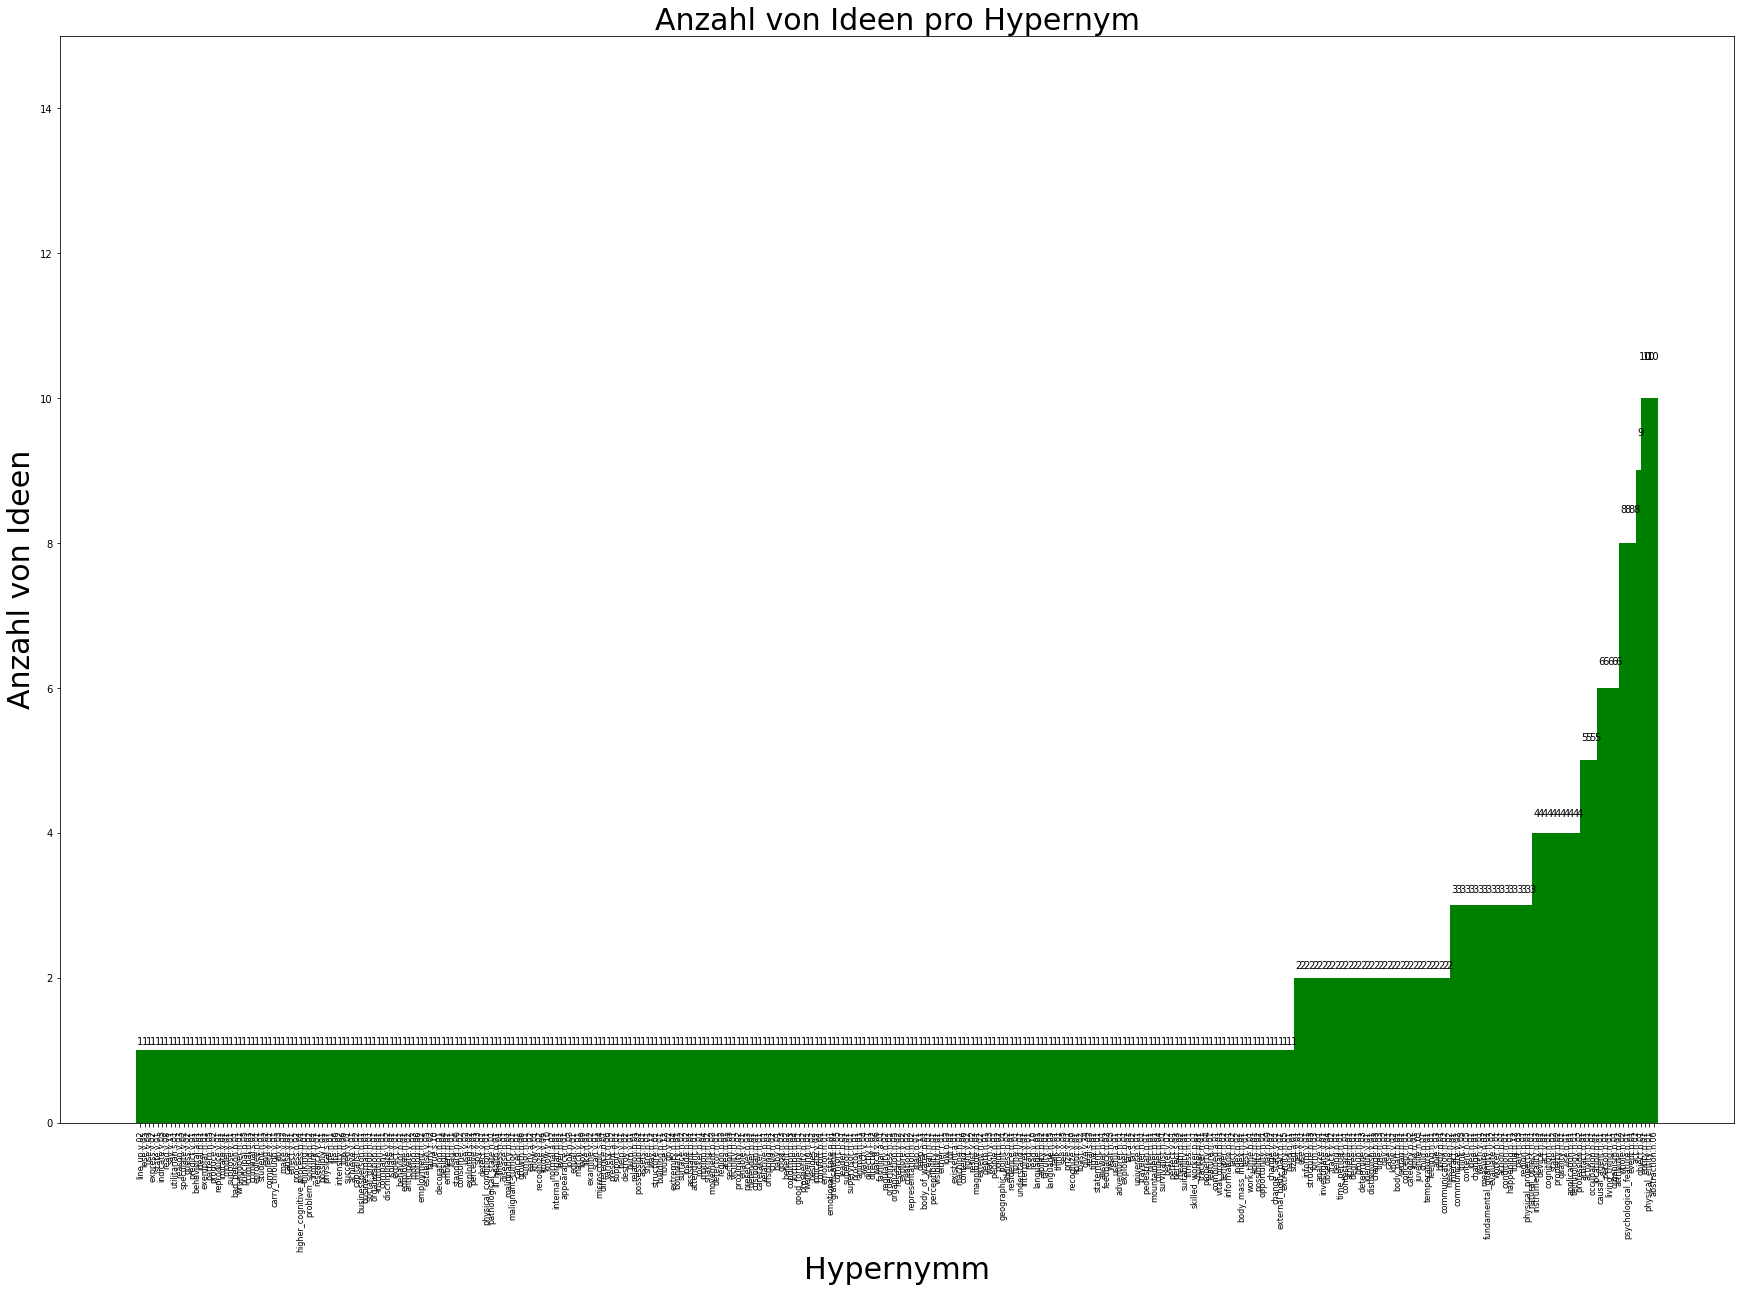

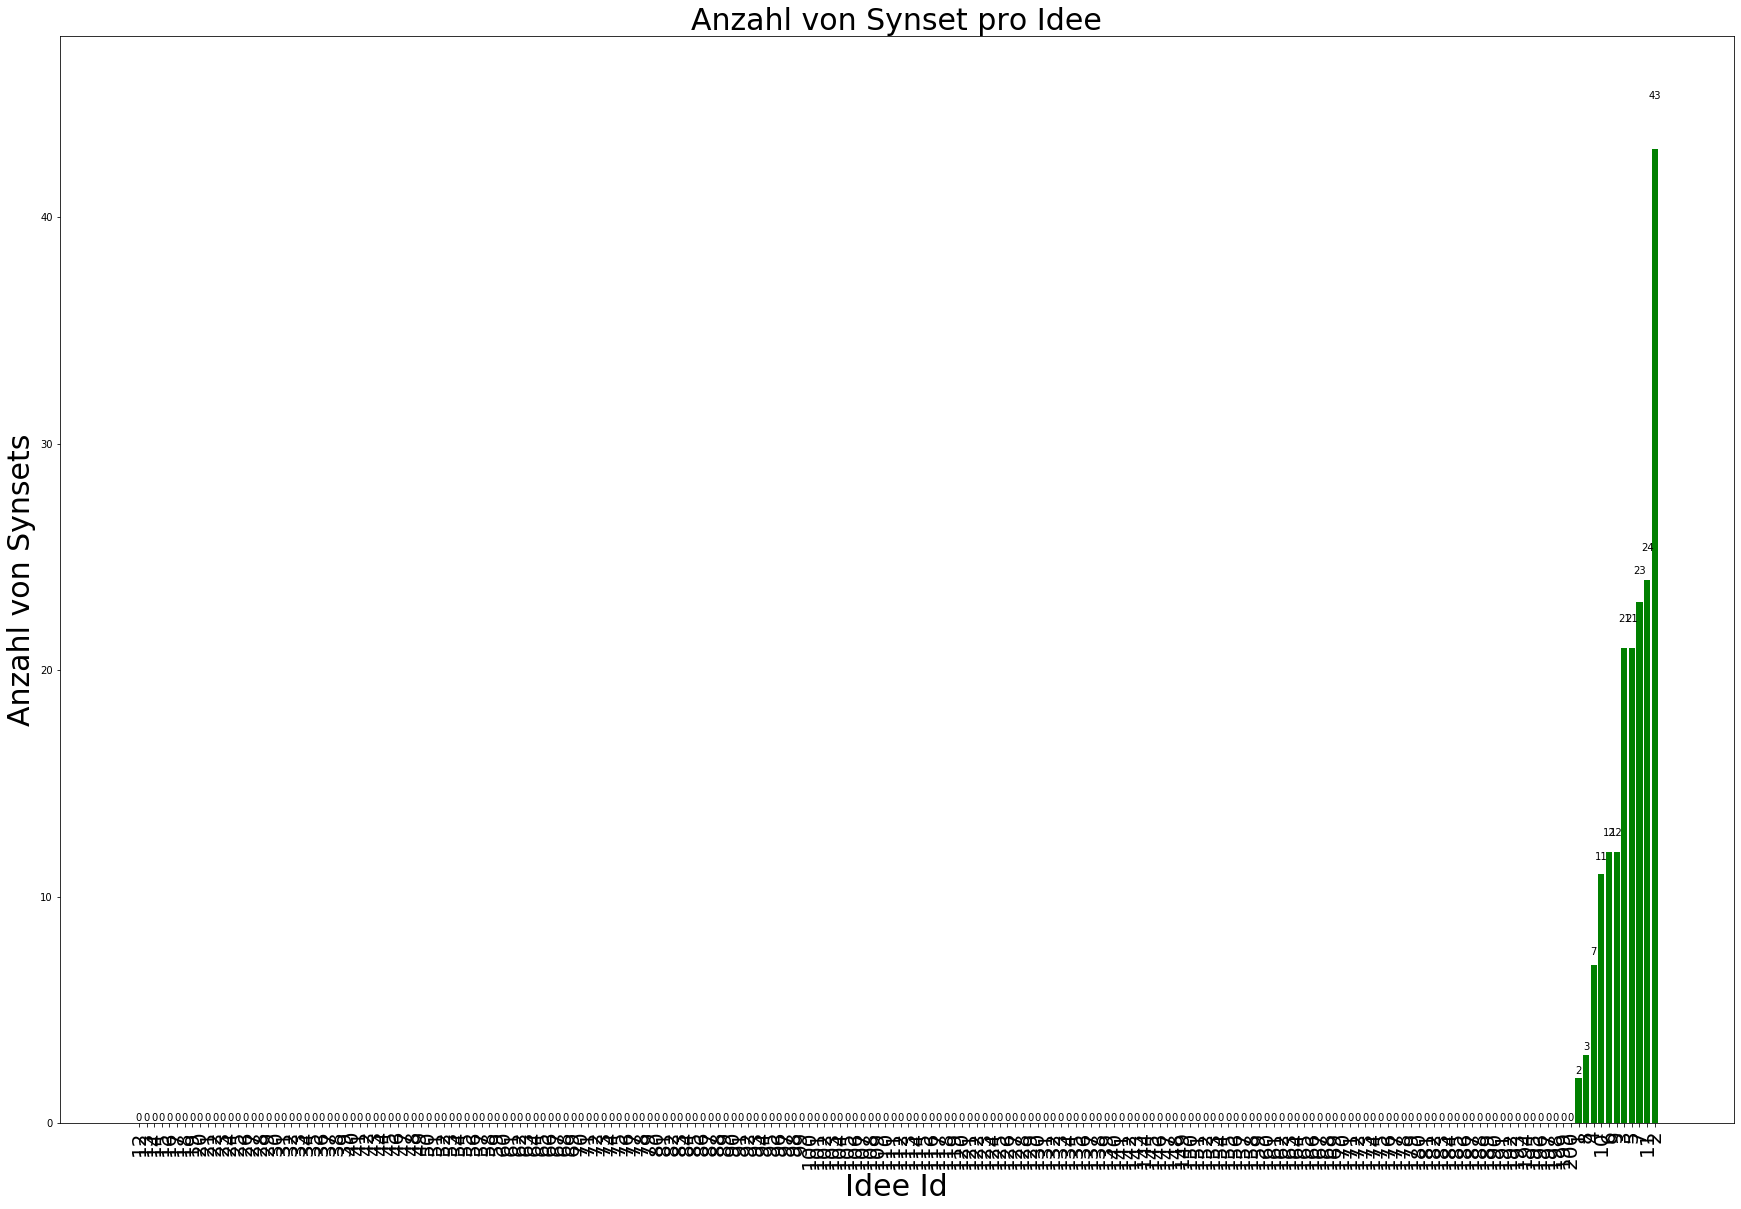

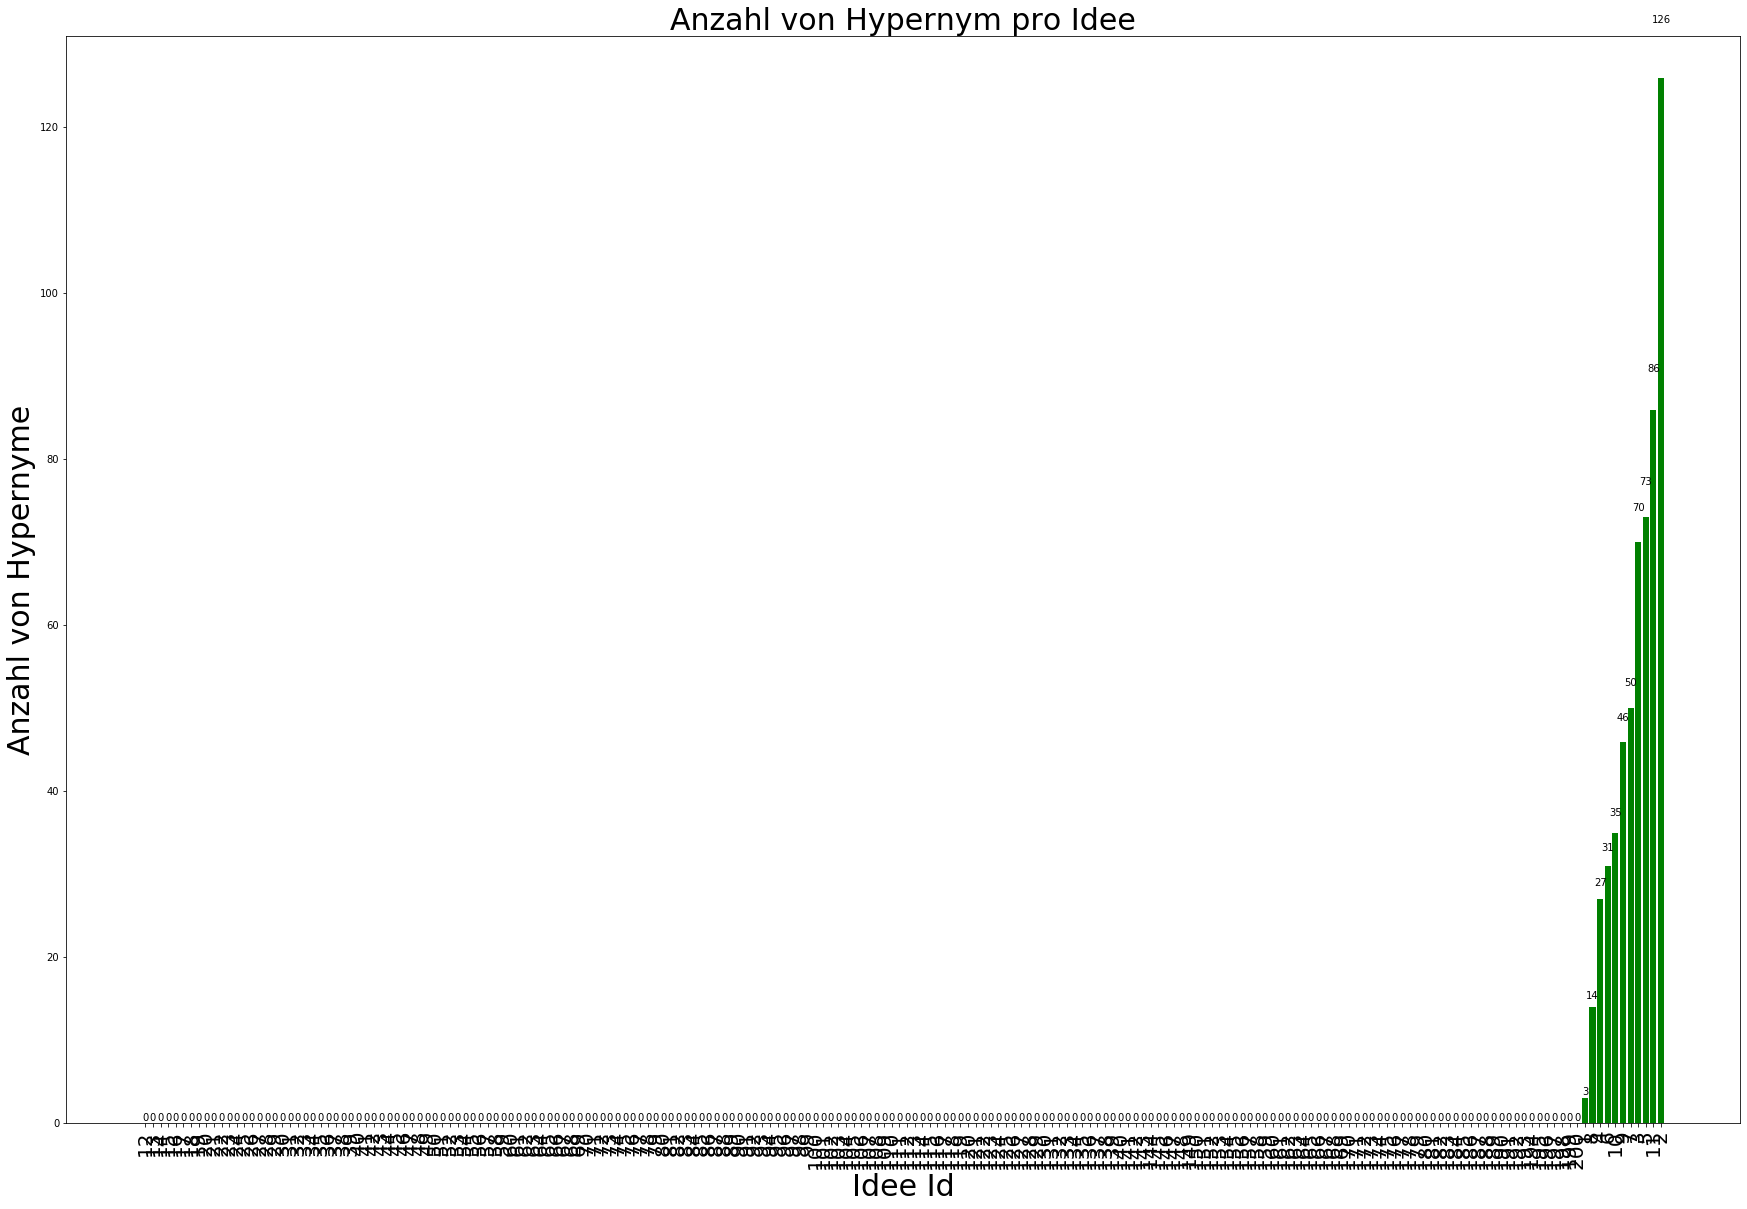

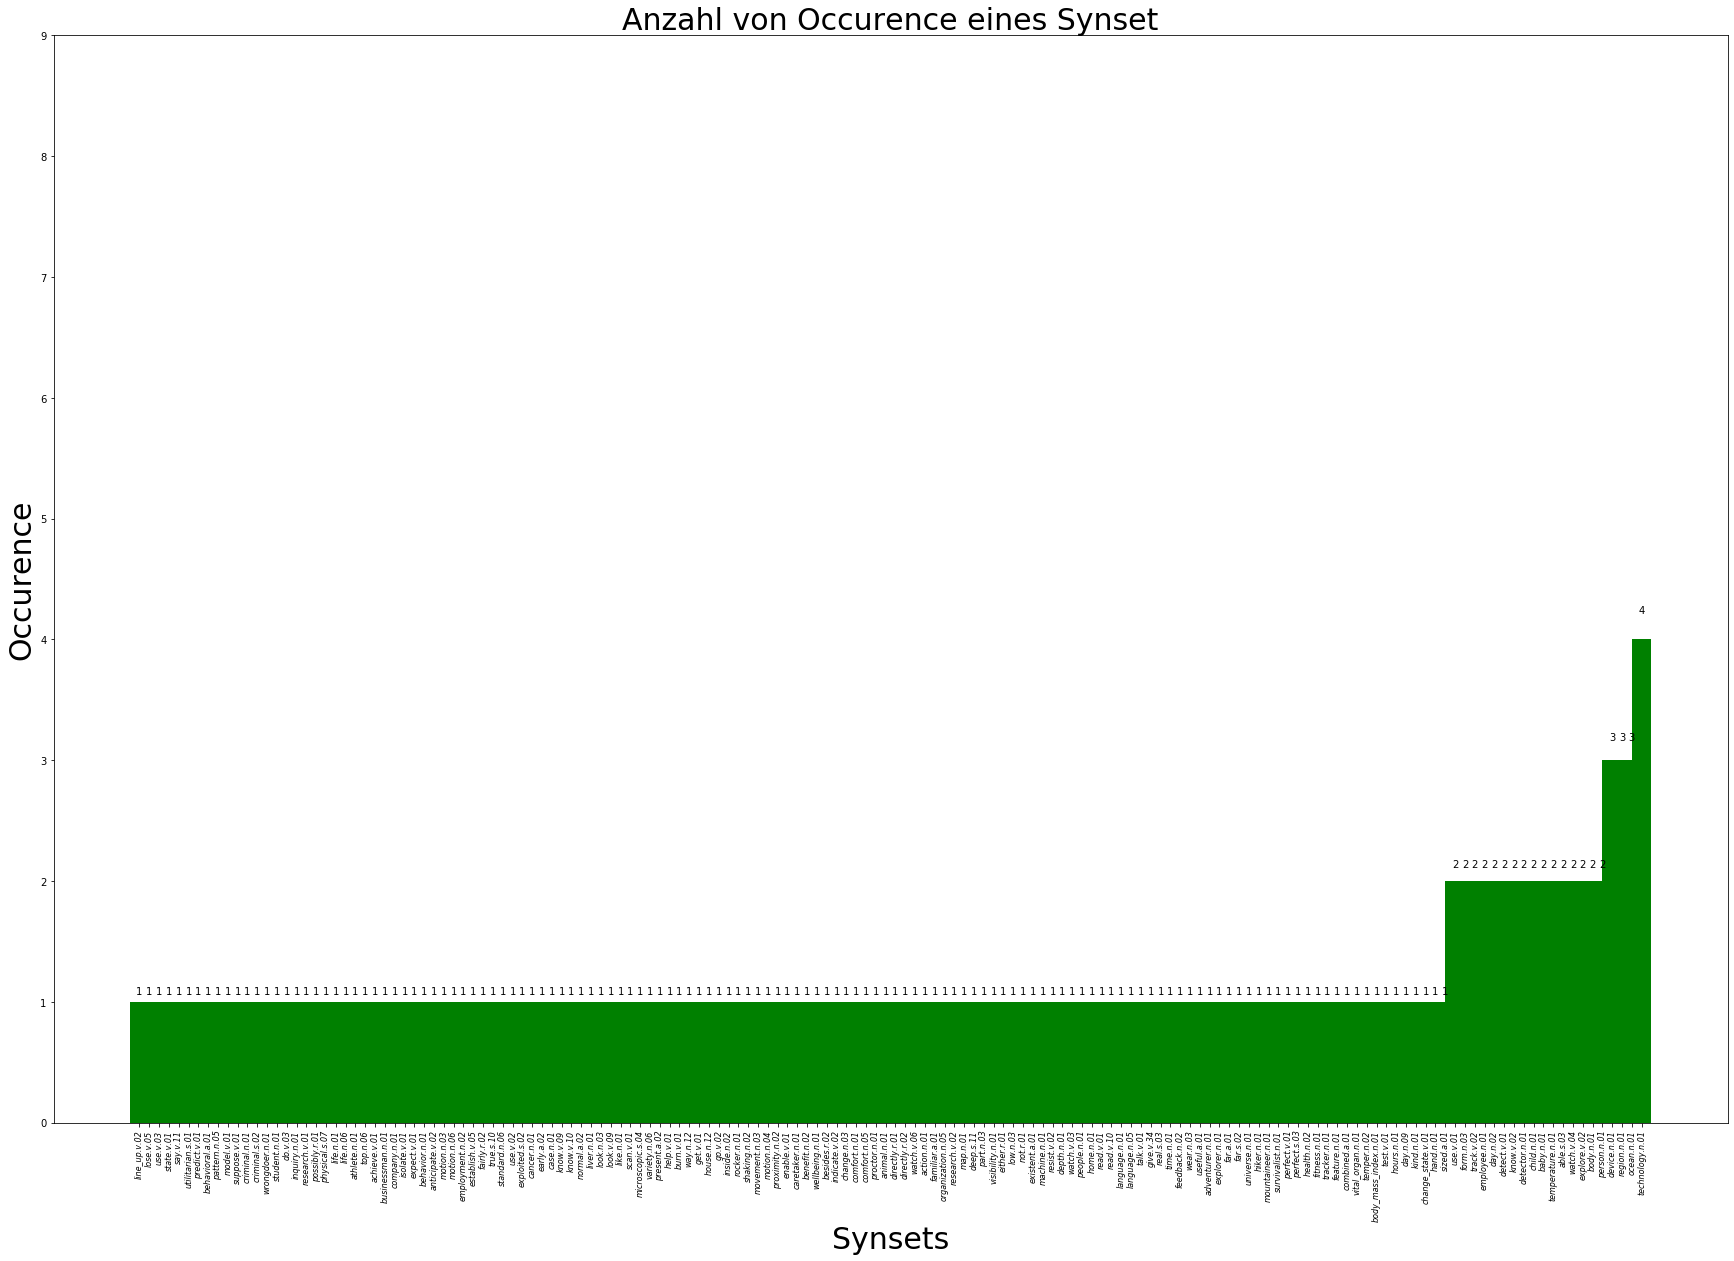

In [21]:
# read file
if __name__ == '__main__':
    #dictionaryTree = {}
    with open('export2.json', 'r') as myfile:
        data = myfile.read()
    ideen_list   = json.loads(data)
    synsetsList  = get_synsetsList(ideen_list)
    hypernymList = get_hypernymDict(synsetsList)
    plot_balken(hypernymList)
    ideen_synset   = mapping_idee_to_synsets(ideen_list)
    ideen_hypernym = mapping_idee_to_hypernym(ideen_synset)
    synsets_occurence = occurence_of_synset(ideen_synset)
    plot_mapping_idee_Synstet(ideen_synset)
    plot_mapping_idee_Hypernym(ideen_hypernym)
    plot_occurence_synset(synsets_occurence)
    #print(ideen_synset)
    #print(ideen_hypernym)
    #plot_dendrogramm(synsetsList,hypernymList)
    
    #synsetsList = {'compact.n.03':[], 'truck.n.01':[]}
    #for idee in ideen_list:
        #for id in hypernymList['physical_entity.n.01']:
            #if idee['id'] == id:
                #print(idee['content'])
    #print(list(synsetsList.keys()) == list(['compact.n.03','truck.n.02']))
    #a = len(synsetsList.keys())
    #print(a)
    dictionaryTree = analyse(synsetsList)
    #add_leaves(dictionaryTree)
    #print(dictionaryTree['entity.n.01'])
    build_tree2(dictionaryTree)
  
    

In [19]:
from anytree.importer import JsonImporter
dictA = '''{"a": "root","children": [{"a": "sub0","children": [{"a": "sub0A","b": "foo"},{"a": "sub0B"}]},{"a": "sub1"}]}'''
importer = JsonImporter()
root = importer.import_(dictA)
DotExporter(root,nodenamefunc=lambda n: n.a).to_picture("root.png")
#for line in DotExporter(root, nodenamefunc=lambda n: n.id()):
#    print(line)
#print(RenderTree(root))

In [17]:
def build_tree(dictionaryTree):
    i=0
    for elem in dictionaryTree:
        #print (elem)
        a    = elem+".png"
        #https://stackoverflow.com/questions/6181935/how-do-you-create-different-variable-names-while-in-a-loop
        globals()['var_%s' % i] = Node(elem, children = [Node(i) for i in dictionaryTree[elem]]) #dynamic variable name create
        #globals()['string%s' % x] = 'Hello'
        i=i+1
      
    for value in dictionaryTree.values():
        for elem in value:
            if elem in dictionaryTree.keys():
                key   = get_key(elem,dictionaryTree)
                
                index_key = list(dictionaryTree.keys()).index(key[0])
                index_elem = list(dictionaryTree.keys()).index(elem)
                name_key = "var" + str(index_key)
                name_elem = 'var'+ str(index_elem)
                #print(index_key,index_elem)
                globals()['var_%s' % index_elem].parent = globals()['var_%s' % index_key]
               # globals()['var_%s' % index_key].children = globals()['var_%s' % index_elem].children
                #children = list( globals()['var_%s' % index_elem].children )
                #print(children)
                #for child in children:
                    #child.parent = globals()['var_%s' % index_key]
                ''''globals()['var_%s' % index_elem].parent = globals()['var_%s' % index_key]
                children = list( globals()['var_%s' % index_key].children )
                m = len(children)
                children2 = []
                for i in range (m-1):
                        for j in range(1,m):
                            if children[i] != children[j]:
                                children2.append(children[i])
                #list(dict.fromkeys(children))
                print("children2",children2)
                children3 = [elem for elem in children if elem not in children2]
                print(children)'''
    return DotExporter(var_22).to_picture("entity.png")
    #return DotExporter(var_14).to_picture("entity3.png")
    #print(list(dictionaryTree.keys()).index("entity.n.01"))
    #print(RenderTree(var_12))
    '''
    print(RenderTree(var_11))
    print(RenderTree(var_10))
    print(RenderTree(var_9))
    print(RenderTree(var_8))
    print(RenderTree(var_7))
    print(RenderTree(var_6))
    print(RenderTree(var_5))
    print(RenderTree(var_4))
    print(RenderTree(var_3))
    print(RenderTree(var_2))
    print(RenderTree(var_1))
    print(RenderTree(var_0))
    '''
    
    #return 0
    
    

In [20]:
#%debug
def plot_dendrogramm(synsetsDict,hypernymlist):
   # helplist = list(synsetsList.keys())
    hypernym = list(hypernymlist.keys())
    n = len(hypernymlist)
   # m = len(helplist)
    distance = np.zeros((n,n),dtype=int)

    
    dictionaryTree = {} #schon bearbeiten knoten
    dictionary_actual = {} #contains new Hypernym which is not in dictionaryTree
    #distance_matrix = 
    for syns in synsetsDict.keys(): #hypernym von jeder synsets builden
        dictionary_actual[syns] = []
        dictionaryTree[syns]    = []
    d=1
    while(len(dictionary_actual) != 0):
        helplist = list(dictionary_actual.keys())
        #print(helplist)
        m = len(helplist)
        for i in range (m-1):
            for j in range(1,m):
                index_i = hypernym.index(helplist[i])
                index_j = hypernym.index(helplist[j])
                distance[index_i][index_j]=distance[index_j][index_i] = d
                distance[index_i][index_i]=distance[index_j][index_j] = 0         
        dictionary_actual = build_dictionary(dictionary_actual)
        for elem in dictionary_actual.copy():
            if elem in dictionaryTree.keys(): #wenn diese elem schon vorhanden ist
                dictionaryTree[elem].extend(dictionary_actual.pop(elem)) #fügt einfach die leaves hinzu und lösch diese aus dem actual schon bearbeiten
                dictionaryTree[elem] = list(dict.fromkeys(dictionaryTree[elem])) #remove duplicate
            else:
                dictionaryTree[elem] = [] #wenn nicht erstellt einen neue Eltern knoten
                dictionaryTree[elem] = dictionary_actual[elem] #fügt die leaves davon
        d += 1
    return distance
    

In [1]:
#from graphviz import Digraph
from graphviz import Graph
#import graphviz
liste1 = ['B','C','E','F']
liste2 = ['G','A']
s = Graph('parent')
#d = graphviz.Graph('parent')
#with d.subgraph() as s:
    #s.attr(rank='same')
for node in liste1:
    s.edge('A',node)
for node in liste2:
    s.edge('W',node)
#s.edge('W','G',rank='same')
#s.group([rank=same,G,F])
   # s.edge('W','O',label='test',len = '5.00')
c = Graph('child')
c.attr(rank='same')
for node in liste1:
    c.node(node)
c.node('G')
s.subgraph(c)
s.view()

'parent.gv.pdf'